In [1]:
#K-folds
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
X_train, X_test, y_train, y_test = \
   train_test_split(X, y,
                    test_size=0.20,
                    stratify=y,
                    random_state=1)


In [4]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


In [5]:
k_folds = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(k_folds):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

mean_acc = np.mean(scores)
std_acc = np.std(scores)

In [6]:
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


**GRID SEARCH CV**

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_range = [0.001, 0.01, 0.1, 1, 10, 100]
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
]
gs = GridSearchCV(pipe_svc, param_grid, scoring='accuracy', cv=10, n_jobs=-1, refit=True)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_


**RANDOMSEARCH CV**

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform, randint

# Pipeline with scaling + SVM
pipe_svc = make_pipeline(StandardScaler(), SVC())

# Define hyperparameter distributions
param_dist = {
    'svc__C': loguniform(1e-3, 1e3),  # Sample C on log scale between 0.001 and 1000
    'svc__gamma': loguniform(1e-4, 1e-1),  # Sample gamma on log scale
    'svc__kernel': ['linear', 'rbf']  # Discrete choice
}

# Randomized search
rand_search = RandomizedSearchCV(
    pipe_svc,
    param_distributions=param_dist,
    n_iter=30,  # Number of random samples
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_
print(rand_search.best_score_)
best_model.predict(X_test)


0.9802197802197803


array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1])

In [9]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.956140350877193


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[71  1]
 [ 2 40]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



Matplotlib is building the font cache; this may take a moment.
c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\pc\AppData

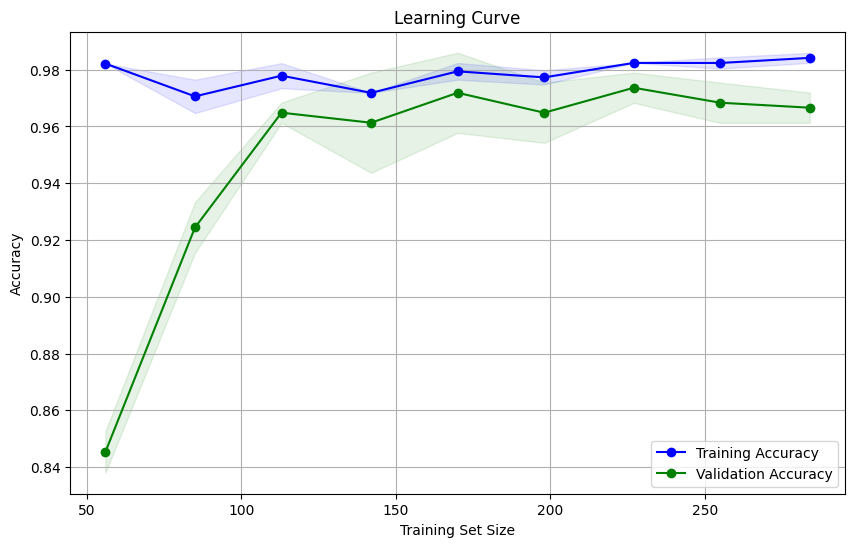

In [11]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=2,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()